
​
## 12-1. 들어가며
​
![content img](https://d3s0tskafalll9.cloudfront.net/media/images/empty.max-800x600.jpg)
​
딥러닝 논문에서는 다양한 방법들을 적용하며, 그 방법 적용 전후의 차이를 실험 결과로 보여줍니다. 이때 논문에는 어느 정도 구현 방법과 실험의 설정이 나와있으니, 하드웨어 자원을 엄청나게 필요로 하거나 특정한 데이터셋이 필요한 경우를 제외하면 어느 정도 따라해볼 수 있는데요. 평소 논문을 보고 이해하는 데 집중하셨다면, 이번 시간에는 모델을 구현하고, 모델에 각 기법을 적용했을 때와 아닐 때를 비교해 보면서 효과를 직접 체감해보는 시간을 갖도록 하겠습니다.
​
### 실습목표
​
___
​
-   직접 ResNet 구현하기
-   모델을 config에 따라서 변경 가능하도록 만들기
-   직접 실험해서 성능 비교하기
​
### 학습내용
​
___
​
1.  Ablation Study
2.  CIFAR-10 데이터셋 준비
3.  블록 구성
4.  VGG Complete Model
5.  VGG-16 vs VGG-19
6.  ResNet Ablation Study

## 12-2. Ablation Study

-   ["In the context of deep learning, what is an ablation study?"](https://www.quora.com/In-the-context-of-deep-learning-what-is-an-ablation-study)

저희가 지금부터 해볼 프로젝트는 **애블레이션 연구(ablation study)** 입니다. 직역하자면 '제거 연구'정도가 되겠네요.

딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시합니다. 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교합니다. 애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험입니다.

아래는 ResNet 논문에서 제시한 residual connection의 애블레이션 연구입니다. 이미지넷(ImageNet) 검증 데이터셋(validation dataset)에 대한 Top-1 error rate을 지표로 사용해 residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교하였습니다. 이 비교를 통해서 ResNet이 residual connection을 활용해서 깊은 네트워크를 쌓았을 때, 이를 통한 성능 향상을 얻을 수 있음을 증명하고 있습니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-2_KU8V5aZ.max-800x600.png)

\[출처: He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.\]

## 12-3. Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

**ResNet**이 막 공개된 시점으로 돌아갔다고 생각해 봅시다. 우리는 이 방법이 논문으로는 유효하다고 들었지만 직접 실험을 해 성능을 평가하고, 다른 실험에 적용해 보기로 합니다.

ResNet의 성능을 평가하기 위해서 원래 논문과 동일한 이미지넷의 훈련/검증 데이터셋을 사용해 학습과 평가를 진행하면 좋겠지만, 우리는 컴퓨팅 자원이 부족하므로 이미지넷보다는 적당한 크기의 CIFAR-10 데이터셋으로 평가해보도록 합시다.

지금부터 우리의 실험은 **CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인하는 것**입니다. ResNet에 대한 설명은 ResNet 이론 자료를 다시 한번 확인하도록 합시다.

-   [Deep residual learning for image recognition](http://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

### 1) CIFAR-10

___

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-1-p-cifar-10.png)

-   [CIFAR-10 from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10)

그럼 우리가 이번에 모델을 사용해서 풀어야 할 문제가 무엇인지 확인해보도록 합시다. CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있습니다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel)입니다. MNIST에서 손글씨가 나타내는 숫자를 분류해내었던 것처럼 CIFAR-10 데이터셋을 사용해 물체의 종류를 분류해보도록 하겠습니다.

먼저 데이터셋을 준비하겠습니다. 만약 텐서플로우에서 제공하는 `tensorflow-datasets` 패키지가 설치되어 있지 않다면 아래 명령어로 설치해 주세요.

```
$ pip install tensorflow-datasets
```

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

CIFAR-10은 대용량 데이터셋은 아니지만 그래도 로드되는 데 꽤 긴 시간이 걸립니다. 잠깐 커피를 드시면서 숨을 돌리셔도 좋습니다.

데이터셋이 준비되면 클래스의 수와 클래스에 따른 이름을 볼 수 있습니다. `DatasetBuilder`의 `info`를 통해 정보를 확인해 보세요.

> ❗️ `tfds.load()`는 기본적으로 `~/tensorflow_datasets` 경로에 데이터셋을 다운로드합니다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, `~/aiffel` 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용하시면 됩니다. 혹시 데이터셋 경로를 바꾸고 싶으시다면, `data_dir` 인자를 사용하세요.


In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 `ds_train.shape` 같은 게 존재하지 않습니다. 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 등 가장 중요한 정보들이 잘 확인되었나요?

### 2) Input Normalization

___

**Data Normalization** 은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것입니다. 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 0~1.0 사이의 값을 가지게 될 거예요. 위의 예를 수식으로 간단하게 쓴다면, (정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값) 이죠.

x−xmin⁡xmax⁡−xmin⁡\\frac{x-x\_{\\min }}{x\_{\\max }-x\_{\\min }}

Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄이는(학습 속도 향상) 거예요.

아래 그림을 보면 왼쪽이 정규화 하지 않은 경우의 Cost function 이고 오른쪽이 정규화 한 Cost function 일 때, 정규화 한 경우가 Local optimum 에서 더 빨리 빠져나올 수 있다는 것을 직관적으로 이해할 수 있습니다.그리고 scikit-learn에서 MinMaxScaler로 쉽게 사용 할 수 있어요.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/image_3GLaa5Y.max-800x600.png)

우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요. 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현합니다. RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이죠. 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지입니다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있습니다.

우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 **정규화(normalize)** 를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

MNIST 데이터셋 클래스는 0부터 9까지의 숫자, 총 10가지가 있습니다. CIFAR-10 데이터셋 또한 이름에서 알 수 있듯이 10개 클래스를 가집니다. 아래 코드로 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인해 보세요!

In [9]:
ds_info.features["label"].num_classes

10

In [10]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

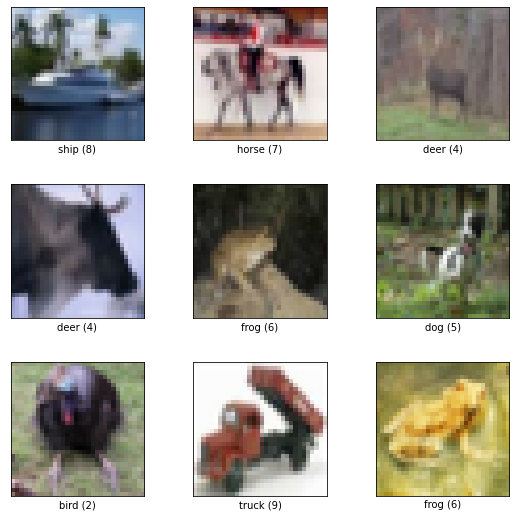

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

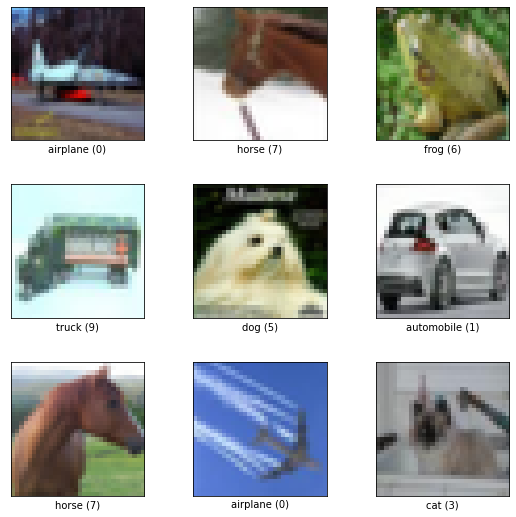

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

모델의 학습을 위한 데이터셋에 대한 확인은 충분히 한 것 같습니다. 이제 본격적으로 코딩을 하면서 모델을 직접 빌딩하는 시간을 갖도록 하겠습니다.

## 12-4. Ablation Study 실습 (2) 블록 구성하기

모델을 프로그램으로 구현하는 과정에서는 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요합니다.

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 **블록(block)** 이라고 부릅니다. **레이어(layer)** 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위입니다. 우리는 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 합니다.

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/resnet.max-800x600.png)

\[https://pytorch.org/assets/images/resnet.png\]

프로젝트로 구현할 **ResNet**을 보면 ResNet-18, 34, 50, 101, 152로 다섯 가지 네트워크가 있습니다. 각 네트워크를 하나씩 구현하는 방법도 있지만 매우 수고스럽고 변경사항이 생기면 모두 고쳐줘야 하는 불편함이 생기게 됩니다. 따라서 이후 실습에서 우리는 ResNet의 기본 구조인 블록을 먼저 구현하겠습니다.

> ResNet을 바로 구현하는 것은 어려울 수 있으므로, 지금부터 조금 더 간단한 블록이 반복되는 VGG를 예시로 구현해 보겠습니다.

### VGG 기본 블록 만들기

___

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/vgg_structure.max-800x600.png)

VGG는 여러 가지 버전이 있습니다. 이 중 VGG의 VGG-16과 VGG-19의 기본 구조가 되는 블록을 만든다고 가정하고 블록을 구현해 봅시다.

블록을 구현하기 위해 모델 구조의 특징을 짚어보겠습니다. VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어집니다. CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있습니다. 그리고 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다. 블록에 따라서 CNN 레이어의 개수 또한 달라집니다. 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다. 따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 합니다.

`block_num`은 레이어의 이름을 붙여주기 위해서 추가되었고 `input_shape`는 summary를 출력하기 위해서 넣어주었습니다.



In [13]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

이제 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 `input_layer` 에 추가를 해 봅시다. 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 `(32,32,3)` 이 됩니다. 이 입력 레이어를 인자로 받아 `build_vgg_block()` 는 블록의 레이어를 build하고 출력값을 얻을 수 있습니다. 이제 케라스의 `Model` 클래스에서 `input`과 `output`을 정의해 주면 간단히 블록의 모델을 확인해볼 수 있습니다.

-   [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [14]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

## 12-5. Ablation Study 실습 (3) VGG Complete Model

이제 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보겠습니다.

### 1) VGG-16

___

먼저 작은 네트워크인 VGG-16을 먼저 만들어 보겠습니다. 블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라집니다. 이는 VGG-16과 VGG-19에 따라서 같이 변화되므로 함수에 전달되어야 합니다. 여기서는 각 블록 별 CNN의 수와 채널을 리스트로 전달했습니다.


In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

### 2) VGG-19

___

위에서 16을 만들어봤으니 쉽게 구성(configuration)을 바꿔서 VGG-19를 만들 수 있습니다.

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

## 12-6. Ablation Study 실습 (4) VGG-16 vs VGG-19

이제 본격적으로 위에서 준비한 데이터셋과 모델의 성능 비교를 위해서 모델을 훈련하고 평가하겠습니다.

VGG는 레이어의 차이를 위해서 **VGG-16**과 **VGG-19**를 비교해보도록 하겠습니다.

우선 CIFAR-10 데이터셋을 불러옵시다.

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

VGG-16 모델을 만들고 훈련시켜 줍니다.

> ❗잠깐
> 
> 이 작업은 시간이 상당히 소요됩니다. BATCH\_SIZE가 커지면 소요시간이 좀 줄어드는 효과가 있습니다만, 1epoch당 1분 이상 소요될 수도 있습니다. 이 훈련은 40Epoch 정도 수행하는 것을 권장하지만, 15Epoch 정도로도 어느 정도 근접하는 성능을 얻을 수는 있을 것입니다.


In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

VGG-19 모델을 만들고 훈련시켜 줍니다.

> 파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸립니다. Epoch 수나 BATCH\_SIZE를 잘 조절해 주세요.

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하겠습니다. 먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해봅시다.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

그리고 검증 정확도(validation accuracy)를 비교해 봅시다.

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# 12-7. 프로젝트: ResNet Ablation Study

### 0) 라이브러리 버전 확인하기

___

사용할 라이브러리 버전을 둘러봅시다.

In [15]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


### 1) ResNet 기본 블록 구성하기

___

이제 실전으로 돌아와서 **ResNet-34**와 **ResNet-50** 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

-   [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)
-   [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

Q1. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.

예시답안

ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. _Learning by Doing_ 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇 번의 경험이 있습니다.  
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.

그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현 방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.

### 2) ResNet-34, ResNet-50 Complete Model

___

> ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

#### ResNet-34

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 `build_resnet()`를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

In [ ]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

이러한 결과가 나와야 합니다. 참고하세요!

```

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_568 (Activation)     (None, 16, 16, 64)   0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
stage2_0_maxpooling (MaxPooling (None, 8, 8, 64)     0           activation_568[0][0]             
__________________________________________________________________________________________________
stage2_1_conv1 (Conv2D)         (None, 8, 8, 64)     36928       stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
stage2_1_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_569 (Activation)     (None, 8, 8, 64)     0           stage2_1_bn1[0][0]               
__________________________________________________________________________________________________
stage2_1_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_569[0][0]             
__________________________________________________________________________________________________
stage2_1_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv2[0][0]             
__________________________________________________________________________________________________
stage2_1_add (Add)              (None, 8, 8, 64)     0           stage2_1_bn2[0][0]               
                                                                 stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
activation_570 (Activation)     (None, 8, 8, 64)     0           stage2_1_add[0][0]               
__________________________________________________________________________________________________
stage2_2_conv1 (Conv2D)         (None, 8, 8, 64)     36928       activation_570[0][0]             
__________________________________________________________________________________________________
stage2_2_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_571 (Activation)     (None, 8, 8, 64)     0           stage2_2_bn1[0][0]               
__________________________________________________________________________________________________
stage2_2_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_571[0][0]             
__________________________________________________________________________________________________
stage2_2_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv2[0][0]             
__________________________________________________________________________________________________
stage2_2_add (Add)              (None, 8, 8, 64)     0           stage2_2_bn2[0][0]               
                                                                 activation_570[0][0]             
__________________________________________________________________________________________________
activation_572 (Activation)     (None, 8, 8, 64)     0           stage2_2_add[0][0]               
__________________________________________________________________________________________________
stage2_3_conv1 (Conv2D)         (None, 8, 8, 64)     36928       activation_572[0][0]             
__________________________________________________________________________________________________
stage2_3_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_573 (Activation)     (None, 8, 8, 64)     0           stage2_3_bn1[0][0]               
__________________________________________________________________________________________________
stage2_3_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_573[0][0]             
__________________________________________________________________________________________________
stage2_3_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv2[0][0]             
__________________________________________________________________________________________________
stage2_3_add (Add)              (None, 8, 8, 64)     0           stage2_3_bn2[0][0]               
                                                                 activation_572[0][0]             
__________________________________________________________________________________________________
activation_574 (Activation)     (None, 8, 8, 64)     0           stage2_3_add[0][0]               
__________________________________________________________________________________________________
stage3_1_conv1 (Conv2D)         (None, 4, 4, 128)    73856       activation_574[0][0]             
__________________________________________________________________________________________________
stage3_1_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_575 (Activation)     (None, 4, 4, 128)    0           stage3_1_bn1[0][0]               
__________________________________________________________________________________________________
stage3_1_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_575[0][0]             
__________________________________________________________________________________________________
stage3_1_short (Conv2D)         (None, 4, 4, 128)    8320        activation_574[0][0]             
__________________________________________________________________________________________________
stage3_1_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv2[0][0]             
__________________________________________________________________________________________________
stage3_1_bn4 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_short[0][0]             
__________________________________________________________________________________________________
stage3_1_add (Add)              (None, 4, 4, 128)    0           stage3_1_bn2[0][0]               
                                                                 stage3_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_576 (Activation)     (None, 4, 4, 128)    0           stage3_1_add[0][0]               
__________________________________________________________________________________________________
stage3_2_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_576[0][0]             
__________________________________________________________________________________________________
stage3_2_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_577 (Activation)     (None, 4, 4, 128)    0           stage3_2_bn1[0][0]               
__________________________________________________________________________________________________
stage3_2_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_577[0][0]             
__________________________________________________________________________________________________
stage3_2_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv2[0][0]             
__________________________________________________________________________________________________
stage3_2_add (Add)              (None, 4, 4, 128)    0           stage3_2_bn2[0][0]               
                                                                 activation_576[0][0]             
__________________________________________________________________________________________________
activation_578 (Activation)     (None, 4, 4, 128)    0           stage3_2_add[0][0]               
__________________________________________________________________________________________________
stage3_3_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_578[0][0]             
__________________________________________________________________________________________________
stage3_3_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_579 (Activation)     (None, 4, 4, 128)    0           stage3_3_bn1[0][0]               
__________________________________________________________________________________________________
stage3_3_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_579[0][0]             
__________________________________________________________________________________________________
stage3_3_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv2[0][0]             
__________________________________________________________________________________________________
stage3_3_add (Add)              (None, 4, 4, 128)    0           stage3_3_bn2[0][0]               
                                                                 activation_578[0][0]             
__________________________________________________________________________________________________
activation_580 (Activation)     (None, 4, 4, 128)    0           stage3_3_add[0][0]               
__________________________________________________________________________________________________
stage3_4_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_580[0][0]             
__________________________________________________________________________________________________
stage3_4_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_581 (Activation)     (None, 4, 4, 128)    0           stage3_4_bn1[0][0]               
__________________________________________________________________________________________________
stage3_4_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_581[0][0]             
__________________________________________________________________________________________________
stage3_4_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv2[0][0]             
__________________________________________________________________________________________________
stage3_4_add (Add)              (None, 4, 4, 128)    0           stage3_4_bn2[0][0]               
                                                                 activation_580[0][0]             
__________________________________________________________________________________________________
activation_582 (Activation)     (None, 4, 4, 128)    0           stage3_4_add[0][0]               
__________________________________________________________________________________________________
stage4_1_conv1 (Conv2D)         (None, 2, 2, 256)    295168      activation_582[0][0]             
__________________________________________________________________________________________________
stage4_1_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_583 (Activation)     (None, 2, 2, 256)    0           stage4_1_bn1[0][0]               
__________________________________________________________________________________________________
stage4_1_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_583[0][0]             
__________________________________________________________________________________________________
stage4_1_short (Conv2D)         (None, 2, 2, 256)    33024       activation_582[0][0]             
__________________________________________________________________________________________________
stage4_1_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv2[0][0]             
__________________________________________________________________________________________________
stage4_1_bn4 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_short[0][0]             
__________________________________________________________________________________________________
stage4_1_add (Add)              (None, 2, 2, 256)    0           stage4_1_bn2[0][0]               
                                                                 stage4_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_584 (Activation)     (None, 2, 2, 256)    0           stage4_1_add[0][0]               
__________________________________________________________________________________________________
stage4_2_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_584[0][0]             
__________________________________________________________________________________________________
stage4_2_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_585 (Activation)     (None, 2, 2, 256)    0           stage4_2_bn1[0][0]               
__________________________________________________________________________________________________
stage4_2_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_585[0][0]             
__________________________________________________________________________________________________
stage4_2_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv2[0][0]             
__________________________________________________________________________________________________
stage4_2_add (Add)              (None, 2, 2, 256)    0           stage4_2_bn2[0][0]               
                                                                 activation_584[0][0]             
__________________________________________________________________________________________________
activation_586 (Activation)     (None, 2, 2, 256)    0           stage4_2_add[0][0]               
__________________________________________________________________________________________________
stage4_3_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_586[0][0]             
__________________________________________________________________________________________________
stage4_3_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_587 (Activation)     (None, 2, 2, 256)    0           stage4_3_bn1[0][0]               
__________________________________________________________________________________________________
stage4_3_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_587[0][0]             
__________________________________________________________________________________________________
stage4_3_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv2[0][0]             
__________________________________________________________________________________________________
stage4_3_add (Add)              (None, 2, 2, 256)    0           stage4_3_bn2[0][0]               
                                                                 activation_586[0][0]             
__________________________________________________________________________________________________
activation_588 (Activation)     (None, 2, 2, 256)    0           stage4_3_add[0][0]               
__________________________________________________________________________________________________
stage4_4_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_588[0][0]             
__________________________________________________________________________________________________
stage4_4_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_589 (Activation)     (None, 2, 2, 256)    0           stage4_4_bn1[0][0]               
__________________________________________________________________________________________________
stage4_4_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_589[0][0]             
__________________________________________________________________________________________________
stage4_4_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv2[0][0]             
__________________________________________________________________________________________________
stage4_4_add (Add)              (None, 2, 2, 256)    0           stage4_4_bn2[0][0]               
                                                                 activation_588[0][0]             
__________________________________________________________________________________________________
activation_590 (Activation)     (None, 2, 2, 256)    0           stage4_4_add[0][0]               
__________________________________________________________________________________________________
stage4_5_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_590[0][0]             
__________________________________________________________________________________________________
stage4_5_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv1[0][0]             
__________________________________________________________________________________________________
activation_591 (Activation)     (None, 2, 2, 256)    0           stage4_5_bn1[0][0]               
__________________________________________________________________________________________________
stage4_5_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_591[0][0]             
__________________________________________________________________________________________________
stage4_5_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv2[0][0]             
__________________________________________________________________________________________________
stage4_5_add (Add)              (None, 2, 2, 256)    0           stage4_5_bn2[0][0]               
                                                                 activation_590[0][0]             
__________________________________________________________________________________________________
activation_592 (Activation)     (None, 2, 2, 256)    0           stage4_5_add[0][0]               
__________________________________________________________________________________________________
stage4_6_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_592[0][0]             
__________________________________________________________________________________________________
stage4_6_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv1[0][0]             
__________________________________________________________________________________________________
activation_593 (Activation)     (None, 2, 2, 256)    0           stage4_6_bn1[0][0]               
__________________________________________________________________________________________________
stage4_6_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_593[0][0]             
__________________________________________________________________________________________________
stage4_6_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv2[0][0]             
__________________________________________________________________________________________________
stage4_6_add (Add)              (None, 2, 2, 256)    0           stage4_6_bn2[0][0]               
                                                                 activation_592[0][0]             
__________________________________________________________________________________________________
activation_594 (Activation)     (None, 2, 2, 256)    0           stage4_6_add[0][0]               
__________________________________________________________________________________________________
stage5_1_conv1 (Conv2D)         (None, 1, 1, 512)    1180160     activation_594[0][0]             
__________________________________________________________________________________________________
stage5_1_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_595 (Activation)     (None, 1, 1, 512)    0           stage5_1_bn1[0][0]               
__________________________________________________________________________________________________
stage5_1_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_595[0][0]             
__________________________________________________________________________________________________
stage5_1_short (Conv2D)         (None, 1, 1, 512)    131584      activation_594[0][0]             
__________________________________________________________________________________________________
stage5_1_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv2[0][0]             
__________________________________________________________________________________________________
stage5_1_bn4 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_short[0][0]             
__________________________________________________________________________________________________
stage5_1_add (Add)              (None, 1, 1, 512)    0           stage5_1_bn2[0][0]               
                                                                 stage5_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_596 (Activation)     (None, 1, 1, 512)    0           stage5_1_add[0][0]               
__________________________________________________________________________________________________
stage5_2_conv1 (Conv2D)         (None, 1, 1, 512)    2359808     activation_596[0][0]             
__________________________________________________________________________________________________
stage5_2_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_597 (Activation)     (None, 1, 1, 512)    0           stage5_2_bn1[0][0]               
__________________________________________________________________________________________________
stage5_2_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_597[0][0]             
__________________________________________________________________________________________________
stage5_2_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv2[0][0]             
__________________________________________________________________________________________________
stage5_2_add (Add)              (None, 1, 1, 512)    0           stage5_2_bn2[0][0]               
                                                                 activation_596[0][0]             
__________________________________________________________________________________________________
activation_598 (Activation)     (None, 1, 1, 512)    0           stage5_2_add[0][0]               
__________________________________________________________________________________________________
stage5_3_conv1 (Conv2D)         (None, 1, 1, 512)    2359808     activation_598[0][0]             
__________________________________________________________________________________________________
stage5_3_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_599 (Activation)     (None, 1, 1, 512)    0           stage5_3_bn1[0][0]               
__________________________________________________________________________________________________
stage5_3_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_599[0][0]             
__________________________________________________________________________________________________
stage5_3_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv2[0][0]             
__________________________________________________________________________________________________
stage5_3_add (Add)              (None, 1, 1, 512)    0           stage5_3_bn2[0][0]               
                                                                 activation_598[0][0]             
__________________________________________________________________________________________________
activation_600 (Activation)     (None, 1, 1, 512)    0           stage5_3_add[0][0]               
__________________________________________________________________________________________________
avg_pool (AveragePooling2D)     (None, 1, 1, 512)    0           activation_600[0][0]             
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 512)          0           avg_pool[0][0]                   
__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 10)           5130        flatten_11[0][0]                 
==================================================================================================
Total params: 21,315,338
Trainable params: 21,298,314
Non-trainable params: 17,024
_____________________________________________________________________________________________
```



#### ResNet-50

위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

In [ ]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

이러한 결과와 '비슷'하게 나와야 합니다. 참고하세요!

```

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_layer (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_layer[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           conv1_bn[0][0]                       
__________________________________________________________________________________________________
pool1_pool (MaxPooling2D)       (None, 8, 8, 64)     0           conv1_relu[0][0]                  
__________________________________________________________________________________________________
conv2_block1_1_conv (Conv2D)    (None, 8, 8, 64)     4160        pool1_pool[0][0]                 
__________________________________________________________________________________________________
conv2_block1_1_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_1_relu (Activation (None, 8, 8, 64)     0           conv2_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_2_conv (Conv2D)    (None, 8, 8, 64)     36928       conv2_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block1_2_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_2_relu (Activation (None, 8, 8, 64)     0           conv2_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_0_conv (Conv2D)    (None, 8, 8, 256)    16640       pool1_pool[0][0]                 
__________________________________________________________________________________________________
conv2_block1_3_conv (Conv2D)    (None, 8, 8, 256)    16640       conv2_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_3_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block1_add (Add)          (None, 8, 8, 256)    0           conv2_block1_0_bn[0][0]          
                                                                 conv2_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block1_out (Activation)   (None, 8, 8, 256)    0           conv2_block1_add[0][0]           
__________________________________________________________________________________________________
conv2_block2_1_conv (Conv2D)    (None, 8, 8, 64)     16448       conv2_block1_out[0][0]           
__________________________________________________________________________________________________
conv2_block2_1_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_1_relu (Activation (None, 8, 8, 64)     0           conv2_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_2_conv (Conv2D)    (None, 8, 8, 64)     36928       conv2_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block2_2_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_2_relu (Activation (None, 8, 8, 64)     0           conv2_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_3_conv (Conv2D)    (None, 8, 8, 256)    16640       conv2_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block2_3_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block2_add (Add)          (None, 8, 8, 256)    0           conv2_block1_out[0][0]           
                                                                 conv2_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block2_out (Activation)   (None, 8, 8, 256)    0           conv2_block2_add[0][0]           
__________________________________________________________________________________________________
conv2_block3_1_conv (Conv2D)    (None, 8, 8, 64)     16448       conv2_block2_out[0][0]           
__________________________________________________________________________________________________
conv2_block3_1_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_1_relu (Activation (None, 8, 8, 64)     0           conv2_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_2_conv (Conv2D)    (None, 8, 8, 64)     36928       conv2_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_2_bn (BatchNormali (None, 8, 8, 64)     256         conv2_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_2_relu (Activation (None, 8, 8, 64)     0           conv2_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_3_conv (Conv2D)    (None, 8, 8, 256)    16640       conv2_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv2_block3_3_bn (BatchNormali (None, 8, 8, 256)    1024        conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv2_block3_add (Add)          (None, 8, 8, 256)    0           conv2_block2_out[0][0]           
                                                                 conv2_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv2_block3_out (Activation)   (None, 8, 8, 256)    0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, 4, 4, 128)    32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 4, 4, 128)    0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_2_relu (Activation (None, 4, 4, 128)    0           conv3_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_0_conv (Conv2D)    (None, 4, 4, 512)    131584      conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_0_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_add (Add)          (None, 4, 4, 512)    0           conv3_block1_0_bn[0][0]          
                                                                 conv3_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_out (Activation)   (None, 4, 4, 512)    0           conv3_block1_add[0][0]           
__________________________________________________________________________________________________
conv3_block2_1_conv (Conv2D)    (None, 4, 4, 128)    65664       conv3_block1_out[0][0]           
__________________________________________________________________________________________________
conv3_block2_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_1_relu (Activation (None, 4, 4, 128)    0           conv3_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_2_relu (Activation (None, 4, 4, 128)    0           conv3_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block2_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_add (Add)          (None, 4, 4, 512)    0           conv3_block1_out[0][0]           
                                                                 conv3_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block2_out (Activation)   (None, 4, 4, 512)    0           conv3_block2_add[0][0]           
__________________________________________________________________________________________________
conv3_block3_1_conv (Conv2D)    (None, 4, 4, 128)    65664       conv3_block2_out[0][0]           
__________________________________________________________________________________________________
conv3_block3_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_1_relu (Activation (None, 4, 4, 128)    0           conv3_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block3_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_2_relu (Activation (None, 4, 4, 128)    0           conv3_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block3_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block3_add (Add)          (None, 4, 4, 512)    0           conv3_block2_out[0][0]           
                                                                 conv3_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block3_out (Activation)   (None, 4, 4, 512)    0           conv3_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block4_1_conv (Conv2D)    (None, 4, 4, 128)    65664       conv3_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block4_1_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, 4, 4, 128)    0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, 4, 4, 128)    147584      conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, 4, 4, 128)    512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, 4, 4, 128)    0           conv3_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_3_conv (Conv2D)    (None, 4, 4, 512)    66048       conv3_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 4, 4, 512)    2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 4, 4, 512)    0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 4, 4, 512)    0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 2, 2, 256)    131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 2, 2, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 2, 2, 256)    0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 2, 2, 1024)   525312      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_add (Add)          (None, 2, 2, 1024)   0           conv4_block1_0_bn[0][0]          
                                                                 conv4_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_out (Activation)   (None, 2, 2, 1024)   0           conv4_block1_add[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block1_out[0][0]           
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 2, 2, 256)    0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_relu (Activation (None, 2, 2, 256)    0           conv4_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_add (Add)          (None, 2, 2, 1024)   0           conv4_block1_out[0][0]           
                                                                 conv4_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_out (Activation)   (None, 2, 2, 1024)   0           conv4_block2_add[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block2_out[0][0]           
__________________________________________________________________________________________________
conv4_block3_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_1_relu (Activation (None, 2, 2, 256)    0           conv4_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_2_relu (Activation (None, 2, 2, 256)    0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_add (Add)          (None, 2, 2, 1024)   0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_out (Activation)   (None, 2, 2, 1024)   0           conv4_block3_add[0][0]           
__________________________________________________________________________________________________
conv4_block4_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_1_relu (Activation (None, 2, 2, 256)    0           conv4_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 2, 2, 256)    0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 2, 2, 1024)   0           conv4_block3_out[0][0]           
                                                                 conv4_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_out (Activation)   (None, 2, 2, 1024)   0           conv4_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 2, 2, 256)    0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_relu (Activation (None, 2, 2, 256)    0           conv4_block5_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block5_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block5_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_add (Add)          (None, 2, 2, 1024)   0           conv4_block4_out[0][0]           
                                                                 conv4_block5_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_out (Activation)   (None, 2, 2, 1024)   0           conv4_block5_add[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_conv (Conv2D)    (None, 2, 2, 256)    262400      conv4_block5_out[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block6_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_1_relu (Activation (None, 2, 2, 256)    0           conv4_block6_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_2_conv (Conv2D)    (None, 2, 2, 256)    590080      conv4_block6_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block6_2_bn (BatchNormali (None, 2, 2, 256)    1024        conv4_block6_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_2_relu (Activation (None, 2, 2, 256)    0           conv4_block6_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_3_conv (Conv2D)    (None, 2, 2, 1024)   263168      conv4_block6_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block6_3_bn (BatchNormali (None, 2, 2, 1024)   4096        conv4_block6_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block6_add (Add)          (None, 2, 2, 1024)   0           conv4_block5_out[0][0]           
                                                                 conv4_block6_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_out (Activation)   (None, 2, 2, 1024)   0           conv4_block6_add[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_conv (Conv2D)    (None, 1, 1, 512)    524800      conv4_block6_out[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_1_relu (Activation (None, 1, 1, 512)    0           conv5_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_2_conv (Conv2D)    (None, 1, 1, 512)    2359808     conv5_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_relu (Activation (None, 1, 1, 512)    0           conv5_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_0_conv (Conv2D)    (None, 1, 1, 2048)   2099200     conv4_block6_out[0][0]           
__________________________________________________________________________________________________
conv5_block1_3_conv (Conv2D)    (None, 1, 1, 2048)   1050624     conv5_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block1_0_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_3_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_add (Add)          (None, 1, 1, 2048)   0           conv5_block1_0_bn[0][0]          
                                                                 conv5_block1_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_out (Activation)   (None, 1, 1, 2048)   0           conv5_block1_add[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, 1, 1, 512)    1049088     conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 1, 1, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 1, 1, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 1, 1, 512)    0           conv5_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_3_conv (Conv2D)    (None, 1, 1, 2048)   1050624     conv5_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_3_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block2_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_add (Add)          (None, 1, 1, 2048)   0           conv5_block1_out[0][0]           
                                                                 conv5_block2_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_out (Activation)   (None, 1, 1, 2048)   0           conv5_block2_add[0][0]           
__________________________________________________________________________________________________
conv5_block3_1_conv (Conv2D)    (None, 1, 1, 512)    1049088     conv5_block2_out[0][0]           
__________________________________________________________________________________________________
conv5_block3_1_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_1_relu (Activation (None, 1, 1, 512)    0           conv5_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_2_conv (Conv2D)    (None, 1, 1, 512)    2359808     conv5_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_bn (BatchNormali (None, 1, 1, 512)    2048        conv5_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_relu (Activation (None, 1, 1, 512)    0           conv5_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_3_conv (Conv2D)    (None, 1, 1, 2048)   1050624     conv5_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_3_bn (BatchNormali (None, 1, 1, 2048)   8192        conv5_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_add (Add)          (None, 1, 1, 2048)   0           conv5_block2_out[0][0]           
                                                                 conv5_block3_3_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_out (Activation)   (None, 1, 1, 2048)   0           conv5_block3_add[0][0]           
==================================================================================================
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________
```

ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다. 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!

하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!

-   [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

### 3) 일반 네트워크(plain network) 만들기

___

#### 블록 코드 수정하기

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

#### 전체 함수 코드 수정하기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 `build_plainnet()`를 만들어 보세요. 이때 입력 이미지의 크기는 `(224, 224, 3)`으로 해주세요.

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

___

#### Ablation Study

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 `tensorflow-datasets`에서 제공하는 `cats_vs_dogs` 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

#### 시각화

학습을 통해 만들어진 `history`를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

#### 추가 실험

시간이 남으면 아래 카탈로그를 보고, `tensorflow-datasets`의 지원하는 다른 데이터셋에 실험을 해봅시다.

-   [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)
